In [38]:
# An isolation forest is a collection of individual tree structures that recursively partition the data set. In each iteration of the process, a random feature is selected, and the data is split based on a randomly chosen value between the minimum and maximum of the chosen feature. This is repeated until the entire data set is partitioned to form an individual tree in the forest. Anomalies generally form much shorter paths from the root than normal data points since they are much more easily isolated. You can find the anomaly score by using a function of the data point involving the average path length.

# Applying an isolation forest to an unlabeled data set in order to catch anomalies is an example of unsupervised anomaly detection.

# Before you start, it is important to note that an isolation forest performs well on high-dimensional data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

columns = ["duration", "protocol_type", "service", "flag", 
          "src_bytes", "dst_bytes", "land", "wrong_fragment",
          "urgent", "hot", "num_failed_logins", "logged_in",
          "num_compromised", "root_shell", "su_attempted",
          "num_root", "num_file_creations", "num_shells", 
          "num_access_files", "num_outbound_cmds", "is_host_login",
          "is_guest_login", "count", "srv_count", "serror_rate",
          "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
          "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
          "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
          "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
          "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
          "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
           "dst_host_srv_rerror_rate", "label"]

# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# kddcup.data.gz The full data set (18M; 743M Uncompressed)
df = pd.read_csv("./data-sample/kddcup.data", sep=",", names=columns, index_col=None)


In [39]:
df.shape

(4898431, 42)

In [40]:
# filter out the entire data frame to only include data entries that involve an HTTP attack,
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

In [41]:
df.shape

(623091, 41)

In [42]:
df["label"].value_counts()

normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: label, dtype: int64

In [19]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [43]:
# the label encoder takes the unique (meaning one entry per categorical value instead of multiple) list of categorical values and assigns a number representing each of them. If you had an array like
# [ "John", "Bob", "Robert"],
# the label encoder would create a numerical representation like
# [0, 1, 2], where 0 represents "John", 1 represents "Bob", and 2 represents "Robert."

for col in df.columns:
    if df[col].dtype == 'object':
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

In [44]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,9,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [45]:
# randomly shuffling all the entries in the data set to avoid the problem of abnormal entries pooling in any one region of the data set.
for f in range(0, 3):
    df = df.iloc[np.random.permutation(len(df))]
    
# create training, testing, and validation data set    
df2 = df[:500000]
labels = df2["label"]
df_validate = df[500000:]

# random_state is a number used to initialize the random number generator that determines what data entries are chosen for the training data set and for the test data set.
x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42)

x_val, y_val = df_validate, df_validate["label"]


In [51]:
print("Shapes: \nx_train: %s \ny_train: %s \n"% (x_train.shape, y_train.shape))
print("x_test: %s\ny_test: %s\n"% (x_test.shape, y_test.shape))
print("x_val: %s\ny_val: %s\n"% (x_val.shape, y_val.shape))

Shapes: 
x_train: (400000, 41) 
y_train: (400000,) 

x_test: (100000, 41)
y_test: (100000,)

x_val: (123091, 41)
y_val: (123091,)



In [54]:
# n_estimators is the number of trees to use in the forest. The default is 100.

# max_samples is the maximum number of data points that the tree should build on. The default is whatever is smaller: 256 or the number of samples in the data set.

# contamination is an estimate of the percentage of the entire data set that should be considered an anomaly/outlier. It is 0.1 by default.

# random_state is the number it will initialize the random number generator with to use during the training process. An isolation forest utilizes the random number generator quite extensively during the training process.

isolation_forest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1, random_state=42)

In [61]:
# Drop label to make it unsupervised. This line is not included int the book
x_train = x_train.drop("label", axis=1)

isolation_forest.fit(x_train)

/Users/huanli/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=256, n_estimators=100, n_jobs=1, random_state=42,
        verbose=0)

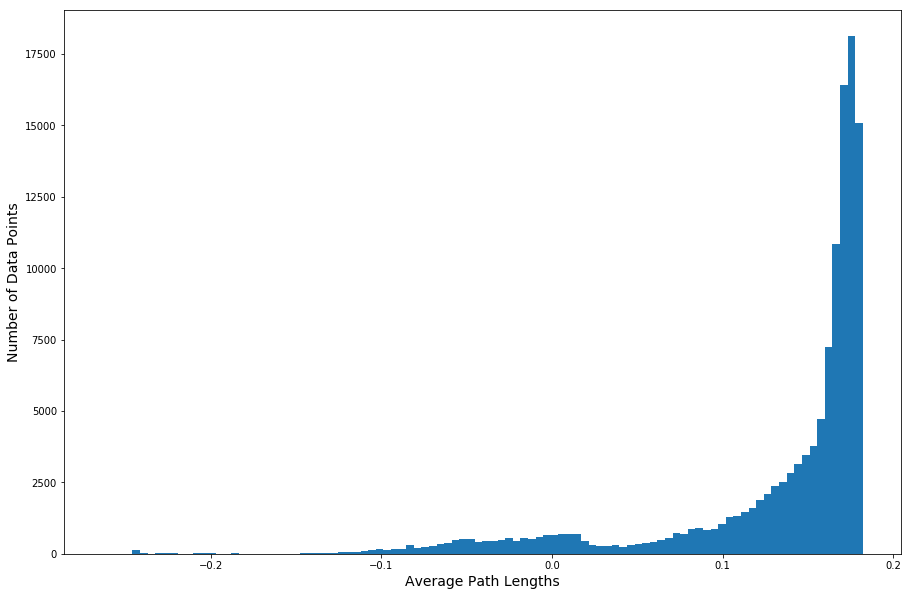

In [62]:
anomaly_scores = isolation_forest.decision_function(x_val)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel("Number of Data Points", fontsize=14)
plt.show()

In [63]:
# Classifying anomalies based on a threshold that you picked from a graph and generating the AUC score from that set of labels for each point

from sklearn.metrics import roc_auc_score

anomalies = anomaly_scores > -0.19
matches = y_val == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies, matches)
print("AUC: {:.2%}".format(auc))

AUC: 99.79%


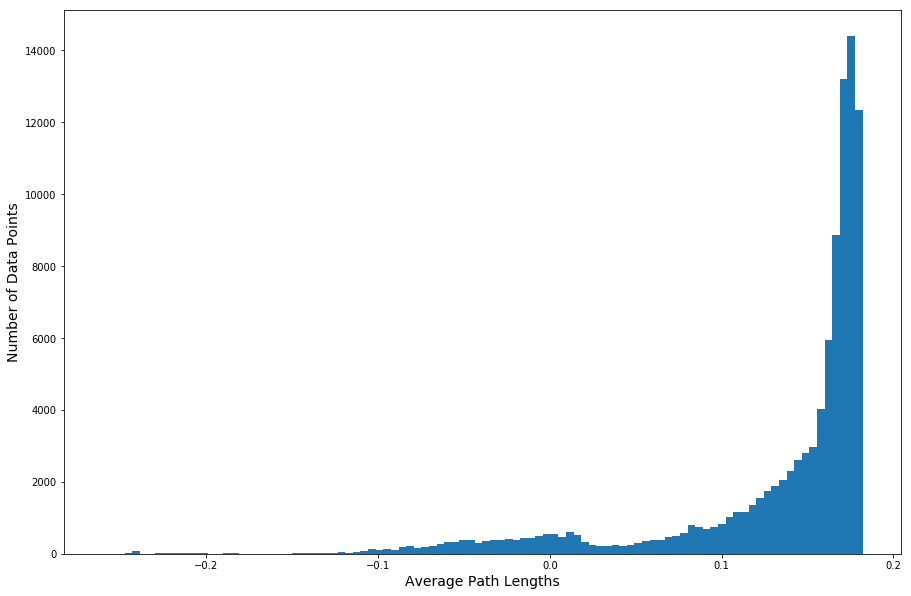

In [64]:
anomaly_scores_test = isolation_forest.decision_function(x_test)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores_test, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel("Number of Data Points", fontsize=14)
plt.show()

In [66]:
anomalies_test = anomaly_scores_test > -0.19
matches = y_test == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies_test, matches)
print("AUC: {:.2%}".format(auc))

AUC: 99.81%
